The data for this notebook comes from our propriety fingerspelling image collection, which per our privacy statement _**should not**_ be seen by anyone but those directly working on this project.

In [2]:
"""
  1. Mount Google Drive (no need to check if already mounted, it does that for you)
  2. 
"""
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!rm -rf "/content/fingerspelling"
!unzip "/content/gdrive/My Drive/CS474 Final Project/CustomFingerspelling/360.zip" > /dev/null

In [0]:
root_dir = "/content/fingerspelling"

In [5]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
from torch.utils.data.sampler import SubsetRandomSampler

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
dataset = torchvision.datasets.ImageFolder(
          root_dir,
          transform = transforms.Compose(
              [
               transforms.RandomGrayscale(0.4),
               transforms.Resize(360), # Make it so we know where we're looking at least
               transforms.RandomResizedCrop(224, (0.5, 1)),
               transforms.RandomHorizontalFlip(),
               transforms.RandomChoice([
                 transforms.RandomPerspective(distortion_scale=0.2, p=0.75),
                 transforms.RandomPerspective(distortion_scale=0.4, p=0.75),
                 transforms.RandomPerspective(distortion_scale=0.6, p=0.75)]
               ),
               transforms.ToTensor(),
               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
               ]))

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [0]:
batch_size = 15
validation_split = 0.08 # Gives roughly 26 in validation
shuffle_dataset = True
random_seed = 2019

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [0]:
for x, y in train_loader:
  for i, j in zip(x, y.tolist()):
    print(dataset.classes[j])
    imshow(i)
  break

In [0]:
[dataset.classes[c] for imgs, batch in validation_loader for c in batch ]

In [9]:
print("Number in the train sampler: {}".format(len(train_indices)))
print("Number in the validate sampler: {}".format(len(val_indices)))

Number in the train sampler: 332
Number in the validate sampler: 28


In [10]:
# Initialize Model
model = torchvision.models.resnet50(pretrained=True)
num_f = model.fc.in_features
model.fc = nn.Linear(num_f, len(dataset.classes))

model = model.cuda() #use GPU

# Initialize Objective and Optimizer and other parameters
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 375MB/s]


In [0]:
import matplotlib.pyplot as plt


In [0]:
# This is what was talked about in the video for memory management
num_epochs = 200
valid_frequency = 1

saved_epoch = -1

train_losses = []
validation_losses = []
train_acc = []
valid_acc = []

def scope():
  model_directory = "/content/gdrive/My Drive/CS474 Final Project/CustomFingerspelling/Models3"
  best_loss = float("inf")

  try:
    #your code for calling dataset and dataloader
    gc.collect()
    torch.cuda.empty_cache()

    loop = tqdm(
        total=(len(train_loader) * num_epochs) +
          (len(validation_loader) * (num_epochs // valid_frequency))
        , position = 0)

    for epoch in range(num_epochs):
      sum_loss = 0
      count_loss = 0
      sum_acc = 0
      count_acc = 0

      for batch_i, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
        optimizer.zero_grad()
        y_hat = model(x)
        y_long = y_truth.long()

        # print("\n\n-----------\ny_hat: {}, y_long: {}\n-----------\n\n".format(y_hat.size(), y_long.size()))
        loss = objective(y_hat, y_long)
        sum_loss += loss.item()
        count_loss += 1

        accuracy = 1- (torch.nonzero(torch.argmax(y_hat, 1) - y_truth).size(0) / len(y_truth))
        sum_acc += accuracy
        count_acc += 1

        loop.set_description("epoch:{}, loss:{:.4f}, accuracy:{:.4f}".format(epoch, loss.item(), accuracy))
        loop.update(1)
        loss.backward()
        optimizer.step()

        # Save model out if it's the new lowest loss.
        if loss.item() < best_loss:
          best_loss = loss.item()
          state = {
              'epoch': epoch,
              'batch_i': batch_i,
              'state': model.state_dict(),
              'optim': optimizer.state_dict(),
              'train_losses': train_losses,
              'train_acc': train_acc,
              'valid_losses': validation_losses,
              'valid_acc': valid_acc,
              'current_loss': loss.item()
          }
          model_file = os.path.join(model_directory, "resnet50.mod")
          torch.save(state, model_file)

      epoch_loss = sum_loss / count_loss
      train_losses.append( (epoch, epoch_loss) )
      epoch_acc = sum_acc / count_acc
      train_acc.append( ( epoch, epoch_acc ) )
      
      if epoch % valid_frequency == 0:
        sum_loss = 0
        count_loss = 0
        sum_acc = 0
        count_acc = 0
        with torch.no_grad():
          for x, y_truth in validation_loader:
            x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
            y_hat = model(x)
            loss = objective(y_hat, y_truth.long())
            sum_loss += loss.item()
            count_loss += 1       
            accuracy = 1- (torch.nonzero(torch.argmax(y_hat, 1) - y_truth).size(0) / len(y_truth))
            sum_acc += accuracy
            count_acc += 1
          
          valid_acc.append((epoch, sum_acc / count_acc))
          validation_losses.append((epoch, sum_loss / count_loss))
      # Plot stuff.
      # plt.plot(*zip(*train_losses), label="Training")
      # plt.plot(*zip(*validation_losses), label="Validation")
      # plt.draw() 
      # plt.pause(0.01)
  except:
    __ITB__()
    raise

In [12]:
scope()

epoch:199, loss:0.9326, accuracy:1.0000:  92%|█████████▏| 4600/5000 [46:59<02:58,  2.24it/s]

In [13]:
print(train_losses)
print(validation_losses)

[(0, 3.364232011463331), (1, 3.3317567991173784), (2, 3.297061775041663), (3, 3.2817957401275635), (4, 3.2853529349617334), (5, 3.270494450693545), (6, 3.2450412149014682), (7, 3.2371721786001455), (8, 3.2290968687637993), (9, 3.2011967845585034), (10, 3.1913302255713423), (11, 3.1581574108289634), (12, 3.1054301054581352), (13, 3.078651749569437), (14, 3.061947190243265), (15, 2.989921642386395), (16, 2.9503473509912905), (17, 2.887723611748737), (18, 2.8699439815852954), (19, 2.741601093955662), (20, 2.731615512267403), (21, 2.6566319465637207), (22, 2.592499525650688), (23, 2.504028797149658), (24, 2.446163405542788), (25, 2.3654811485953955), (26, 2.2987408430679985), (27, 2.2262789373812466), (28, 2.1342673042546147), (29, 2.1540027701336406), (30, 2.037486967833146), (31, 2.0160455340924472), (32, 1.8867738195087598), (33, 1.9473122824793276), (34, 1.8212717356889143), (35, 1.8198101313217827), (36, 1.7083268839380015), (37, 1.7112610599269038), (38, 1.688453373701676), (39, 1.63

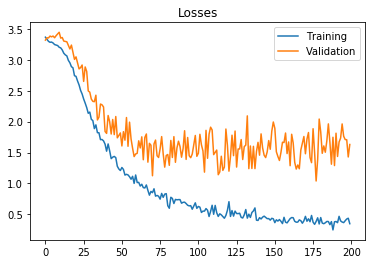

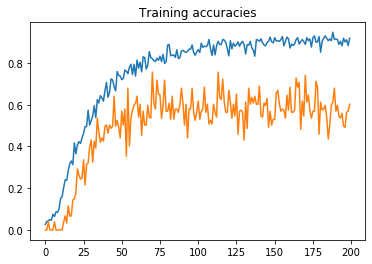

In [14]:
plt.title("Losses")
plt.plot(*zip(*train_losses), label="Training")
plt.plot(*zip(*validation_losses), label="Validation")
plt.legend(loc="upper right")
plt.show()

plt.plot(*zip(*train_acc), label="Training")
plt.plot(*zip(*valid_acc), label="Validation")
plt.title("Training accuracies")
plt.show()

In [0]:
# Save that model out.
torch.save(model.state_dict(), "/content/gdrive/My Drive/CS474 Final Project/CustomFingerspelling/Models3/resnet50_end200.mod")


# Validate Transfer Learning

In [0]:
"""
  1. Mount Google Drive (no need to check if already mounted, it does that for you)
  2. 
"""
from google.colab import drive
drive.mount('/content/gdrive')

root_dir = "/content/gdrive/My Drive/models/"

In [0]:
model_file = "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/loss_0.0304_epoch_4.mod"
loaded = torch.load(model_file)
# print(loaded)
model.load_state_dict(loaded)


In [0]:
model_file = "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/loss_0.0304_epoch_4.mod"

model = ConvNetwork(3, len(dataset.dataset_folder.classes), dimensions=128).cuda()
model.load_state_dict(torch.load(model_file))

In [0]:
# !cd "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/" && unzip Photos.zip
!#mkdir "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle"
#!mkdir "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle/name"

!ls "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle/name"

In [0]:
# michelle_set = ASLDataset("/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet", "Michelle", size=224)
michelle_set = torchvision.datasets.ImageFolder(
          "/content/gdrive/My Drive/CS474 Final Project/Kaggle ASL Alphabet/Michelle",
          transform = transforms.Compose(
              [
               transforms.Resize(224),
               transforms.CenterCrop(224), # Make it so we know where we're looking at least
              #  transforms.RandomResizedCrop(224, (0.8, 1)),
               transforms.ToTensor(),
               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
               ]))

michelle_loader = DataLoader(michelle_set, batch_size=10)

In [0]:
print(len(michelle_set))
print(len(michelle_loader))

In [0]:
michelle_set.classes

In [0]:
batches = [model(i.cuda()) for i, j in michelle_loader]
"".join([dataset.classes[torch.argmax(item)] for batch in batches for item in batch])

In [0]:
sum = 0
for i, j in michelle_loader:
  sum += 1
  res = model(i.cuda())
  chosen = torch.argmax(res, dim=1)
  print(chosen)
  actual = [dataset.classes[a] for a in j.tolist()]
  solved = [dataset.classes[a] for a in chosen.tolist()]
  for c, v in enumerate(zip(actual, solved)):
    a, s = v
    print("Actual: {} Guess: {}".format(a, s))
    try:
      imshow(i[c])
    except:
      pass

  if sum > 0:
    break

In [0]:
sum = 0
for i, j in validation_loader:
  sum += 1
  res = model(i.cuda())
  chosen = torch.argmax(res, dim=1)
  print(chosen)
  actual = [dataset.dataset_folder.classes[a] for a in j.tolist()]
  solved = [dataset.dataset_folder.classes[a] for a in chosen.tolist()]
  for c, v in enumerate(zip(actual, solved)):
    a, s = v
    print("Actual: {} Guess: {}".format(a, s))
    try:
      imshow(i[c])
    except:
      pass

  if sum > 0:
    break

In [0]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils


In [0]:
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

In [0]:
for x, y in michelle_loader:
  show_imgs(x)


# SSH Access

If ssh_connect is True, an ssh server will be set up on the hosting server. Ergo power.

In [0]:
ssh_connect = False
if ssh_connect:
  import random, string, getpass

  password = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(20))
  alias = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(8))
  ! echo root:$password | chpasswd

  ! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
  ! mkdir -p /var/run/sshd
  ! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config && echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
  ! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc && echo "export LD_LIBRARY_PATH" >> /root/.bashrc
  get_ipython().system_raw('/usr/sbin/sshd -D &')

  print('sshpass -p {} ssh -o "StrictHostKeyChecking no" -J serveo.net root@{}'.format(password, alias))
  ! ssh -o "StrictHostKeyChecking no" -R $alias:22:localhost:22 serveo.net